# Quickstart guide to mapping and modelling disease

This practical is written to give you a rapid overview of how to get started building and analysing models. The learning aim here is not to teach everything, but to present one workflow that illustrates how you can move from an experimental dataset, to gene network maps, to models. Everything in this guide is expanded on in more depth later, including the practical and theoretical aspects, but you should be able to adapt this as a starting point for your own data.

## How mutation of APC alters cancer signalling 

We have chosen an example to get started:

"Differential RNA-seq analysis comparing APC-defective and APC-restored SW480 colorectal cancer cells"
https://doi.org/10.1016/j.gdata.2016.02.001

Adenomatous polyposis coli (APC) tumour suppressor gene is mutated in 80% of colorectal cancers (CRC). Its mutation is a well studied step in the Vogelstein model of tumour development. In this dataset APC has been restored in a CRC cell line, and gene expression changes measured with RNASeq. This dataset allows us to explore the role of APC in the control of the cancer phenotype.

In this tutorial we: 

* Process the raw data
* Perform differential expression analysis to identify genes activated and inhibited by the reintroduction of APC
* Use GSEA to identify pathways changed by the presence or absence of APC (to be confirmed)
* Develop maps of signalling
* Convert these maps into models

In [1]:
import pandas as pd

# Loading and processing the input data

The key steps here are: 
- reading in the data from published data files
  
- convert raw counts to a dataframe with total counts per gene, per condition <- This is the input to differential expression analysis
  
- convert rpkm data to tpm (which is generally accepted to be a better way to compare expression between samples - notes on what this means here https://www.rna-seqblog.com/rpkm-fpkm-and-tpm-clearly-explained/) <- This is the input to PCA and other data analysis (such as expresssion heatmaps)
  
- perform a principal component analysis (PCA) to confirm that the samples are distinct (to ensure that the analysis will be sensible)

We note that there are many ways to do this, and this example is illustrative. If you have experience with transcriptomics analysis this may be very familiar to you.

### Reading in the data

In [2]:
## rpkm_data
rpkm_data = pd.read_csv("./GSE76307_gene_level.rpkm.txt", sep = "\t", index_col = "Description")
## raw counts data
raw_counts = pd.read_csv("./GSE76307_transcript_counts.table.txt", sep = "\t", index_col = "Unnamed: 0")

In [3]:
raw_counts.head()

,sw480_APC_1,sw480_APC_2,sw480_APC_3,sw480_CONTROL_1,sw480_CONTROL_2,sw480_CONTROL_3,sw480-1,sw480-2,sw480-3,cds_length,gene_name
NM_000014,1,1,3,1,2,2,3,2,2,4653,A2M
NM_000015,1,0,0,0,2,1,1,3,1,1317,NAT2
NM_000016,1038,1126,1098,1285,1037,1306,1022,1059,1057,2603,ACADM
NM_000017,133,111,103,171,136,174,143,147,125,1917,ACADS
NM_000018,8699,8232,8364,8888,8426,9188,10982,10844,11450,2292,ACADVL


### Curating the raw counts data - converting from transcript level to gene level

In [4]:
## The original data is presented per gene transcript, and to get per gene counts we just need 
## to sum up the counts for all the transcripts of the same gene.

# Sum up the transcripts by gene name
raw_counts = raw_counts.groupby(['gene_name']).sum()
# Remove the cds_length column (we dont need it)
raw_counts = raw_counts.drop("cds_length", axis =1)

### The raw counts data is now ready for input into pathway analysis tools

In [5]:
raw_counts.head()

,sw480_APC_1,sw480_APC_2,sw480_APC_3,sw480_CONTROL_1,sw480_CONTROL_2,sw480_CONTROL_3,sw480-1,sw480-2,sw480-3
gene_name,,,,,,,,,
A1BG,3,0,2,0,0,2,0,1,3
A1BG-AS1,10,4,3,6,4,10,6,13,6
A1CF,6,0,6,0,0,6,6,18,6
A2M,1,1,3,1,2,2,3,2,2
A2M-AS1,3,6,3,4,3,3,6,11,16


### Converting the RPKM data to TPM

In [6]:
rpkm_data.head()

,Name,sw480.1,sw480.2,sw480.3,sw480_APC_1,sw480_APC_2,sw480_APC_3,sw480_CONTROL_1,sw480_CONTROL_2,sw480_CONTROL_3
Description,,,,,,,,,,
DDX11L1,NR_046018,0.029243,0.000000,0.028825,0.000000,0.000000,0.000000,0.028771,0.032629,0.000000
WASH7P,NR_024540,10.022390,9.784377,10.255849,8.056397,7.294954,7.735621,7.657351,9.202215,8.199277
LOC729737,NR_039983,0.308885,0.281063,0.260970,0.572778,0.510475,0.507493,0.269165,0.167401,0.259120
LOC100132062,NR_028325,0.077384,0.022004,0.032690,0.043484,0.034878,0.011772,0.032629,0.037004,0.020941
LOC100288069,NR_033908,4.686485,5.611010,4.758363,3.776909,3.001679,3.752356,3.882773,3.853025,3.037023


In [7]:
## remove the name column
rpkm_data = rpkm_data.drop("Name", axis =1)

### Convert rpkm to TPM

In [8]:
## TPM = (rpkm/total reads in sample) * 1 million
TPM_data = pd.DataFrame()

for col in rpkm_data.columns:
    totalreads = rpkm_data[col].sum()
    
    TPM_data[col] = rpkm_data[col].apply(lambda row: (row/totalreads) * 10**6)

In [9]:
TPM_data.head()

,sw480.1,sw480.2,sw480.3,sw480_APC_1,sw480_APC_2,sw480_APC_3,sw480_CONTROL_1,sw480_CONTROL_2,sw480_CONTROL_3
Description,,,,,,,,,
DDX11L1,0.073737,0.000000,0.071810,0.000000,0.000000,0.000000,0.070465,0.079016,0.000000
WASH7P,25.271794,24.974742,25.549966,19.396767,17.000899,18.372652,18.754201,22.284504,19.992728
LOC729737,0.778863,0.717417,0.650144,1.379034,1.189663,1.205333,0.659232,0.405385,0.631826
LOC100132062,0.195126,0.056166,0.081439,0.104692,0.081284,0.027960,0.079914,0.089611,0.051061
LOC100288069,11.817130,14.322172,11.854310,9.093372,6.995417,8.912112,9.509596,9.330662,7.405333


### We now have:
####  - raw counts data (use for input to DESeq and other tools requiring the raw counts)
####  - TPM data (use for visualisation, GSEA, and other similar tools requiring normalised data)

### Perform PCA to check samples are distinct

In [10]:
# Scale the data
from sklearn.preprocessing import StandardScaler
scaled_TPM = StandardScaler().fit_transform(TPM_data.T)

In [11]:
## Perform PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_TPM)

In [12]:
## Make a dataframe and calculate the percentage contribution of each PC
principal_Df = pd.DataFrame(data = principal_components
             , columns = ['PC1', 'PC2'])

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.46778784 0.21758848]


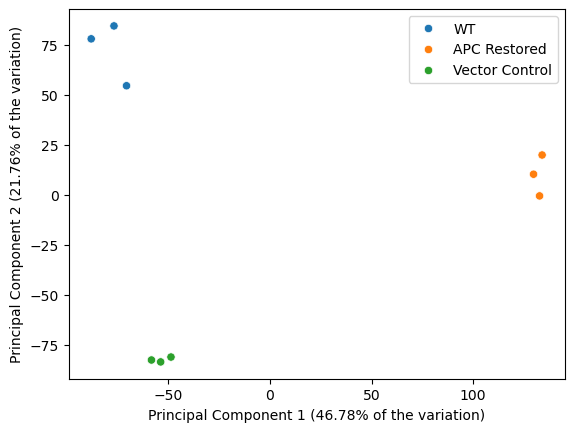

In [13]:
## Plot the PCs

## This can all be made to look a lot nicer and a bit more robust
import matplotlib.pyplot as plt
import seaborn as sns

g = sns.scatterplot(x = principal_Df["PC1"], y = principal_Df["PC2"], hue = ["WT", "WT", "WT"
                                                                             , "APC Restored", "APC Restored", "APC Restored"
                                                                             , "Vector Control", "Vector Control","Vector Control"])

plt.xlabel("Principal Component 1 ({}% of the variation)".format((pca.explained_variance_ratio_[0]*100).round(2)))
plt.ylabel("Principal Component 2 ({}% of the variation)".format((pca.explained_variance_ratio_[1]*100).round(2)))
#plt.legend(*g.legend_elements())


plt.show()

### PC1 seems to correspond to the mutation to APC, whilst PC2 is the action of the vector

# Differential expression using DESeq2 

Generally this would be done in R, but as a python implementation is available we are using it. Here we identify genes showing substantial and significant changes (achieved by examining log fold changes, LFC, and p values) across the datasets. In this particular set we have three conditions; WT, APC restored, and control. The difference between WT and Control will be due to the vector only, so can be used to exclude a subset of false positives.

### Set up our data

In [14]:
## raw counts is fed into deseq2 transposed compared to our usual format
counts_df = raw_counts.T

## We remove genes with very low counts (<10 counts across our samples - this number is arbitrary and can be changed)
genes_to_keep = counts_df.columns[counts_df.sum(axis=0) >= 10]
counts_df = counts_df[genes_to_keep]

In [15]:
counts_df.head()

gene_name,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A4GALT,A4GNT,AAAS,AACS,AACSP1,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
sw480_APC_1,3,10,6,1,3,56,0,1769,1004,1,...,1181,3173,5611,231,576,1185,504,5068,1362,721
sw480_APC_2,0,4,0,1,6,49,0,1613,858,0,...,1152,3173,5673,232,567,1056,470,4459,1247,700
sw480_APC_3,2,3,6,3,3,37,0,1661,852,2,...,1140,3035,5720,187,591,1082,449,4781,1190,663
sw480_CONTROL_1,0,6,0,1,4,101,1,3163,732,4,...,1208,2945,6892,84,252,1637,708,7802,1342,870
sw480_CONTROL_2,0,4,0,2,3,84,1,2814,627,3,...,1090,2600,6026,78,241,1431,576,7876,1111,698


In [16]:
## We make our metadata matrix - in this case we just have one condition with 3 levels
conditions = ["APC_restored"] * 3 + ["Vector_control"] * 3 + ["WT"] * 3

metadata = pd.DataFrame(conditions, index= raw_counts.columns, columns=["condition"])

In [17]:
metadata.head()

,condition
sw480_APC_1,APC_restored
sw480_APC_2,APC_restored
sw480_APC_3,APC_restored
sw480_CONTROL_1,Vector_control
sw480_CONTROL_2,Vector_control


## Run deseq2 with Control as the "base factor" (will do a comparison of the other two factors against the control)

In [18]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

In [19]:
## We make the deseqdataset (the data structure deseq uses)
inference = DefaultInference(n_cpus=8)
dds_control = DeseqDataSet(
    counts=counts_df,
    metadata=metadata,
    design_factors="condition",
    refit_cooks=True,
    inference=inference,
    ref_level = ["condition", "Vector_control"])

/home/manager/miniconda/envs/quickstart/lib/python3.12/site-packages/pydeseq2/dds.py:262: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(


In [20]:
## Run deseq2 (differential expression analysis)
dds_control.deseq2()

Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 7.80 seconds.

Fitting dispersion trend curve...
... done in 0.48 seconds.

Fitting MAP dispersions...
... done in 9.08 seconds.

Fitting LFCs...
... done in 4.46 seconds.

Replacing 0 outlier genes.



In [21]:
## Look at the log fold change values
dds_control.varm["LFC"].head()

,intercept,condition_WT_vs_Vector-control,condition_APC-restored_vs_Vector-control
gene_name,,,
A1BG,-0.441702,0.691594,0.974328
A1BG-AS1,1.882842,0.199113,-0.125481
A1CF,0.654134,1.609879,0.758728
A2M,0.513933,0.295419,0.033407
A2M-AS1,1.201970,1.157953,0.217497


### Calcluate p values and shrink LFCs for APC mut vs Control

In [22]:
## APC mut vs Control

## Set up the pvalue calculation
stat_res_APCvsControl = DeseqStats(dds_control, inference=inference, contrast = ["condition", "APC-restored", "Vector-control"], quiet = True)

## Calculate p values
stat_res_APCvsControl.summary(quiet = True)

## We shrink our fold changes
stat_res_APCvsControl.lfc_shrink(coeff="condition_APC-restored_vs_Vector-control")

Log2 fold change & Wald test p-value: condition APC-restored vs Vector-control
              baseMean  log2FoldChange     lfcSE      stat        pvalue  \
gene_name                                                                  
A1BG          1.201651        1.405658  1.971293  0.713064  4.758063e-01   
A1BG-AS1      6.768256       -0.181031  0.752535 -0.240562  8.098949e-01   
A1CF          5.196975        1.094613  1.217595  0.898996  3.686550e-01   
A2M           1.888791        0.048197  1.301256  0.037038  9.704543e-01   
A2M-AS1       6.021168        0.313782  0.847275  0.370343  7.111272e-01   
...                ...             ...       ...       ...           ...   
ZXDC       1443.856959       -0.470899  0.055632 -8.464600  2.570341e-17   
ZYG11B      600.154339       -0.442238  0.082066 -5.388831  7.091743e-08   
ZYX        7164.599004       -0.699490  0.071309 -9.809317  1.026612e-22   
ZZEF1      1355.558492        0.019842  0.064987  0.305322  7.601212e-01   
ZZZ3     

In [23]:
## Save our output
stat_res_APCvsControl.results_df.to_csv("APC_APC_restored_vs_Vector_control_LFC.csv")

In [24]:
stat_res_APCvsControl.results_df.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_name,,,,,,
A1BG,1.201651,0.180957,0.721700,0.713064,0.475806,0.572295
A1BG-AS1,6.768256,-0.089017,0.530195,-0.240562,0.809895,0.860515
A1CF,5.196975,0.317548,0.695572,0.898996,0.368655,0.465634
A2M,1.888791,0.011922,0.644330,0.037038,0.970454,0.980445
A2M-AS1,6.021168,0.137336,0.565584,0.370343,0.711127,0.783101


### Calcluate p values and shrink LFCs for WT vs Control

In [25]:
## WT vs Control

## Set up the pvalue calculation
stat_res_WTvsControl = DeseqStats(dds_control, inference=inference, contrast = ["condition", "WT", "Vector-control"], quiet = True)

## Calculate p values
stat_res_WTvsControl.summary(quiet = True)

## We shrink our fold changes
stat_res_WTvsControl.lfc_shrink(coeff="condition_WT_vs_Vector-control")

Log2 fold change & Wald test p-value: condition WT vs Vector-control
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
gene_name                                                                     
A1BG          1.201651        0.997759  1.996456  0.499765  0.617240       NaN
A1BG-AS1      6.768256        0.287260  0.725313  0.396049  0.692069  0.795916
A1CF          5.196975        2.322565  1.173724  1.978799  0.047839  0.102805
A2M           1.888791        0.426200  1.255552  0.339452  0.734269       NaN
A2M-AS1       6.021168        1.670572  0.779613  2.142823  0.032127  0.073608
...                ...             ...       ...       ...       ...       ...
ZXDC       1443.856959        0.021101  0.053701  0.392929  0.694372  0.797543
ZYG11B      600.154339       -0.038230  0.079391 -0.481539  0.630134  0.749167
ZYX        7164.599004        0.104478  0.070832  1.475017  0.140208  0.246142
ZZEF1      1355.558492        0.195391  0.064248  3.041194  0.

In [26]:
## Save our output
stat_res_WTvsControl.results_df.to_csv("APC_WT_vs_Vector-control_LFC.csv")

In [27]:
### To get the final comparison (APC vs WT) we need to rerun deseq2 with WT as the "base factor"

In [28]:
## We make the deseqdataset (the data structure deseq uses)
inference = DefaultInference(n_cpus=8)
dds_WT = DeseqDataSet(
    counts=counts_df,
    metadata=metadata,
    design_factors="condition",
    refit_cooks=True,
    inference=inference,
    ref_level = ["condition", "WT"])

/home/manager/miniconda/envs/quickstart/lib/python3.12/site-packages/pydeseq2/dds.py:262: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(


In [29]:
## Run deseq2 (differential expression analysis)
dds_WT.deseq2()

Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 7.27 seconds.

Fitting dispersion trend curve...
... done in 0.46 seconds.

Fitting MAP dispersions...
... done in 8.34 seconds.

Fitting LFCs...
... done in 4.22 seconds.

Replacing 0 outlier genes.



### Calculate p values and shrink LFC for APC vs WT

In [30]:
## APC vs WT

## Set up the pvalue calculation
stat_res_APCvsWT = DeseqStats(dds_WT, inference=inference, contrast = ["condition", "APC-restored", "WT"], quiet = True)

## Calculate p values
stat_res_APCvsWT.summary(quiet = True)

## We shrink our fold changes
stat_res_APCvsWT.lfc_shrink(coeff="condition_APC-restored_vs_WT")

Log2 fold change & Wald test p-value: condition APC-restored vs WT
              baseMean  log2FoldChange     lfcSE       stat        pvalue  \
gene_name                                                                   
A1BG          1.201651        0.407889  1.825976   0.223382  8.232386e-01   
A1BG-AS1      6.768256       -0.468315  0.738741  -0.633937  5.261220e-01   
A1CF          5.196975       -1.227944  1.089815  -1.126745  2.598503e-01   
A2M           1.888791       -0.377969  1.258358  -0.300367  7.638976e-01   
A2M-AS1       6.021168       -1.356779  0.758126  -1.789648  7.351052e-02   
...                ...             ...       ...        ...           ...   
ZXDC       1443.856959       -0.492001  0.055598  -8.849281  8.808462e-19   
ZYG11B      600.154339       -0.404009  0.082180  -4.916141  8.826699e-07   
ZYX        7164.599004       -0.803968  0.071111 -11.305796  1.228359e-29   
ZZEF1      1355.558492       -0.175550  0.064411  -2.725463  6.421131e-03   
ZZZ3     

In [31]:
## Save our output
stat_res_APCvsWT.results_df.to_csv("APC_APC-restored_vs_WT_LFC.csv")

## Gene set overlaps

We have now performed differential expression - to get genes of interest we need to calculate overlaps. The genes changed by APC manipulation should be those that overlap between the two APC mut comparisons, but excluding those different between WT and control

We can illustrate the overlaps by making a Venn diagram

In [32]:
## APCrest vs WT
APCrest_vs_WT = stat_res_APCvsWT.results_df[stat_res_APCvsWT.results_df["padj"] <= 0.05]

APCrest_vs_WT = APCrest_vs_WT[abs(APCrest_vs_WT["log2FoldChange"]) > 2]

APCrest_vs_WT_genes = set(APCrest_vs_WT.index.tolist())

In [33]:
## APCmut vs Control
APCrest_vs_Control = stat_res_APCvsControl.results_df[stat_res_APCvsControl.results_df["padj"] <= 0.05]

APCrest_vs_Control = APCrest_vs_Control[abs(APCrest_vs_Control["log2FoldChange"]) > 2]

APCrest_vs_Control_genes = set(APCrest_vs_Control.index.tolist())

In [34]:
## WT vs Control
WT_vs_Control = stat_res_WTvsControl.results_df[stat_res_WTvsControl.results_df["padj"] <= 0.05]

WT_vs_Control = WT_vs_Control[abs(WT_vs_Control["log2FoldChange"]) > 2]

WT_vs_Control_genes = set(WT_vs_Control.index.tolist())

## Make a venn diagram

In [35]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

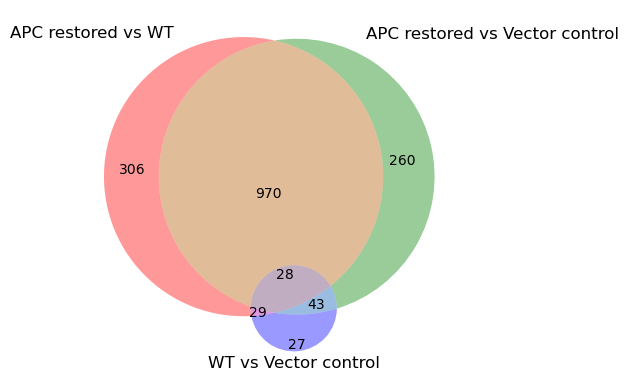

In [36]:
venn3([APCrest_vs_WT_genes, APCrest_vs_Control_genes, WT_vs_Control_genes]
     ,set_labels = ("APC restored vs WT", "APC restored vs Vector control", "WT vs Vector control"))
plt.show()

971 genes are overlapping in the mutant conditions and not involved in the vector. Reassuringly, we also find relatively few in the WT vs control set.

In [37]:
APCrest_genes = list((APCrest_vs_Control_genes & APCrest_vs_WT_genes) - WT_vs_Control_genes)

## Visualise data for confirmation

Here we seek to confirm that the genes identified are correct by returning to the TPM data, and plotting a heatmap of the expression of the genes identified as differentially expressed. This seems obvious, but in addition to offering a visualisation of the effect it confirms that our analysis has been sound. To draw out the clusters of genes associated with each condition, we further cluster the heatmap.

In [38]:
heatmap_genes = TPM_data.T[APCrest_genes].T

heatmap_genes = heatmap_genes.loc[~(heatmap_genes==0).all(axis=1)]


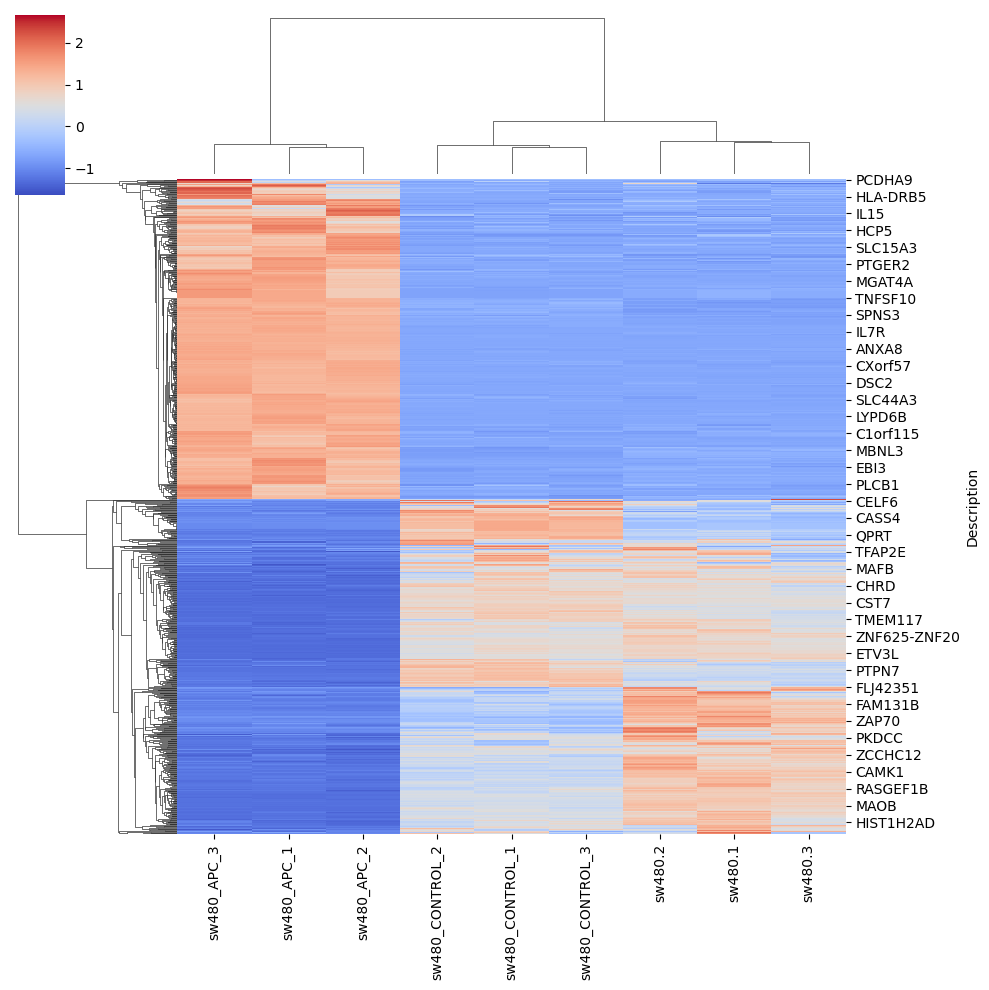

In [39]:
import seaborn as sns
sns.clustermap(heatmap_genes, z_score= 0, metric= "euclidean", cmap = "coolwarm")
plt.show()

## Pathway analysis

here we use two common tools; GSEA and GProfiler to identify functions that the genes are involved in. These may confirm elements of the biology we are looking to test, and could assist us in our later modelling; alternatively, if we are exploring the dataset, it draws out key features and phenotypes to be aware of.

from gprofiler import GProfiler

gp = gprofiler(return_dataframe=True)
#gp = gprofiler()
gp.profile(organism='hsapiens',
            query=APCmut_genes)

In [40]:
import gseapy as gp

enr = gp.enrichr(gene_list=APCrest_genes, # or "./tests/data/gene_list.txt",
                 gene_sets=['MSigDB_Hallmark_2020','KEGG_2021_Human'],
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )



In [41]:
import pickle

#filehandler = open("enrichr_object.pkl", 'wb') 
#pickle.dump(enr, filehandler)

filehandler = open("enrichr_object.pkl", "rb") 
enr = pickle.load(filehandler)

In [42]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    enr.results.sort_values(by=['Adjusted P-value'])
    display(enr.results[enr.results["Adjusted P-value"] < 0.05])

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,Inflammatory Response,45/200,2.854500e-18,1.313070e-16,0,0,5.917439,239.050535,RTP4;CXCL6;CSF3;CSF1;PTGER2;ITGB3;EBI3;PTAFR;L...
1,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,39/200,7.703329e-14,1.771766e-12,0,0,4.903980,148.073413,CXCL6;CSF2;SDC4;CSF1;PLEK;TNFAIP2;TNFAIP3;CXCL...
2,MSigDB_Hallmark_2020,KRAS Signaling Up,37/200,1.795914e-12,2.753734e-11,0,0,4.585082,124.005859,SNAP25;SPON1;CSF2;SATB1;CXCR4;TNFAIP3;PTGS2;HD...
3,MSigDB_Hallmark_2020,Interferon Gamma Response,34/200,1.571238e-10,1.806924e-09,0,0,4.123272,93.078693,RTP4;CD274;SAMD9L;CIITA;TNFAIP2;TNFAIP3;PTGS2;...
4,MSigDB_Hallmark_2020,Allograft Rejection,31/200,9.992728e-09,9.193309e-08,0,0,3.680347,67.797183,CSF1;GCNT1;FASLG;HDAC9;CTSS;ICAM1;CCND2;NLRP3;...
5,MSigDB_Hallmark_2020,Complement,27/200,1.487081e-06,1.140095e-05,0,0,3.117419,41.831702,ITGAM;LRP1;PLEK;TNFAIP3;CXCL1;CLU;CTSS;PIK3R5;...
6,MSigDB_Hallmark_2020,IL-6/JAK/STAT3 Signaling,16/87,3.882501e-06,2.551358e-05,0,0,4.473534,55.735904,CNTFR;CSF2;CSF1;ITGB3;EBI3;CXCL1;CXCL3;PIK3R5;...
7,MSigDB_Hallmark_2020,Epithelial Mesenchymal Transition,26/200,4.691694e-06,2.697724e-05,0,0,2.981390,36.580814,CXCL6;ECM1;SDC4;LRP1;WIPF1;NTM;ITGB3;COL12A1;T...
8,MSigDB_Hallmark_2020,Interferon Alpha Response,16/97,1.649554e-05,8.431052e-05,0,0,3.919178,43.159635,RTP4;CD74;SAMD9L;CSF1;SAMD9;SP110;IL15;DDX60;I...
9,MSigDB_Hallmark_2020,IL-2/STAT5 Signaling,24/199,3.779811e-05,1.738713e-04,0,0,2.730403,27.804378,CDKN1C;IL10;ECM1;CSF2;CSF1;PTGER2;TNFRSF9;PTH1...


### The below gene list can also be pasted into online tools such as:
 - Enrichr: https://maayanlab.cloud/Enrichr/ 
 - Gprofiler: https://biit.cs.ut.ee/gprofiler/gost 
 - Genetrail: https://genetrail.bioinf.uni-sb.de 
 
 A review of some advice for this is here: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9371296/ 

In [43]:
for item in APCrest_genes:
    print(item)

LOC100129722
ELFN2
CYTH4
CORO2B
APLNR
ETV3L
MGST1
COL8A2
TMEM125
KRTAP2-3
SOWAHB
SLC15A3
GALNT3
ABCB4
ZNF878
EPHA1
IGDCC3
CCL2
CR2
SCEL
ZNF385C
ANXA8L2
EBF3
TG
PCDHA12
CENPVP1
SP8
TTC29
CELF6
FEZ1
FHDC1
ESRP1
IL17C
GSTM4
MEIS3
ITIH3
NEURL
NELL2
PMP22
WNT10A
ARHGDIB
TMC5
PTAFR
RUNX2
DES
FOXI1
CXCL6
WBSCR28
ID1
FAM84B
LDLRAD4
CNTLN
IGFL2
SPIB
CSF2
CHRD
PDE2A
GRIP2
LZTS1
KRT7
SULF1
MUC4
NTN4
CRB2
KLF15
NR2F1
CX3CL1
NCALD
UGT1A6
RLBP1
ZNF704
PARM1
HIST1H2BK
ANK3
PTPN13
ESRRB
HLA-DRA
MB
C8orf47
ADRA2C
SCN4A
SCML1
LRRC8B
Sep-04
FAM179A
ARHGEF16
KRT74
TMC4
TFAP2E
SV2B
UBXN10
ZEB1
CYGB
OTOP1
SKAP1
HIST1H3D
IL15
EPS8L3
TPSG1
BAMBI
CRB3
KSR2
SRGN
PDGFRB
PLEKHS1
LTK
HIST2H2BE
PCDHA9
ILDR1
CST1
DCDC2
PCDHA13
SGPP2
ZDHHC22
ZNF711
GPR56
FAM198B
NRG1
JPH3
NOXO1
CXCL10
C6orf52
RAC2
LOC100506071
FAM131B
EYA1
LPAR1
STXBP6
GPR98
TBX3
GOLGA6B
KRT39
CD52
MCTP2
C3
CCDC154
PCDHA1
SEZ6
IL2RB
C11orf86
CNTFR
ALOX5AP
TTBK1
IL7R
CD4
MARVELD3
OLR1
SDR16C5
RLN2
PRRG4
SPINT1
ZAP70
HCP5
RORC
PPP1R1B
IRF6
GATA6
MAGEA1

# Getting started with mapping networks

We've got a long list of genes now to start building a network. This is useful, but too long to practically turn into a network immediately;there is no practical way to turn >10s of genes into a network. Fundamentally, we need to prioritise which genes we study first. This can be done based on biological knowledge, effectively using a subset of well studied genes as a prior- in this instance we could pick one GSEA term for example as our starting point, using our function of interest to guide us.

What we will do for the purpose of this tutorial initially is to prioritise based on increasing the significance and fold change thresholds. To simplify this process we rewrite some of the code above into subroutines

In [44]:
## Function to get the top differentially expressed genes from a dataframe (a), given a threshold for:
## - pvalue (thresholdP)
## - FoldChange (thresholdF)
def topDiff(a,thresholdP, thresholdF):
    ## APCmut vs WT
    out = a.results_df[a.results_df["padj"] <= thresholdP]

    out = out[abs(out["log2FoldChange"]) > thresholdF]

    result = set(out.index.tolist())
    
    return(result)

## Function to return lists of genes for each condition pair given two thresholds (P - pvalue, F - FoldChange)
def threshold(P,F):
    APCrest_vs_WT_genes = topDiff(stat_res_APCvsWT, P, F)
    APCrest_vs_Control_genes = topDiff(stat_res_APCvsControl, P, F)
    WT_vs_Control_genes =  topDiff(stat_res_WTvsControl, P, F)
    APCmut_genes = list((APCrest_vs_Control_genes & APCrest_vs_WT_genes) - WT_vs_Control_genes)
    return(APCmut_genes)

In [45]:
print(len(threshold(0.05,2))) # original thresholds
print(len(threshold(0.003,4))) # three sigma, 2^4 fold difference
print(len(threshold(0.00007,8))) # four sigma, 2^8 fold difference

970
238
11


The selected thresholds are arbitrary, but can be useful to thin the large list.

In [46]:
smallset = threshold(0.00007,8)
for item in smallset: 
    print(item)

MIR205HG
CXCL14
CCL2
HLA-DRB1
ALPL
CXCL6
PLEKHS1
GALNT3
PTPRZ1
BMPR1B
C3


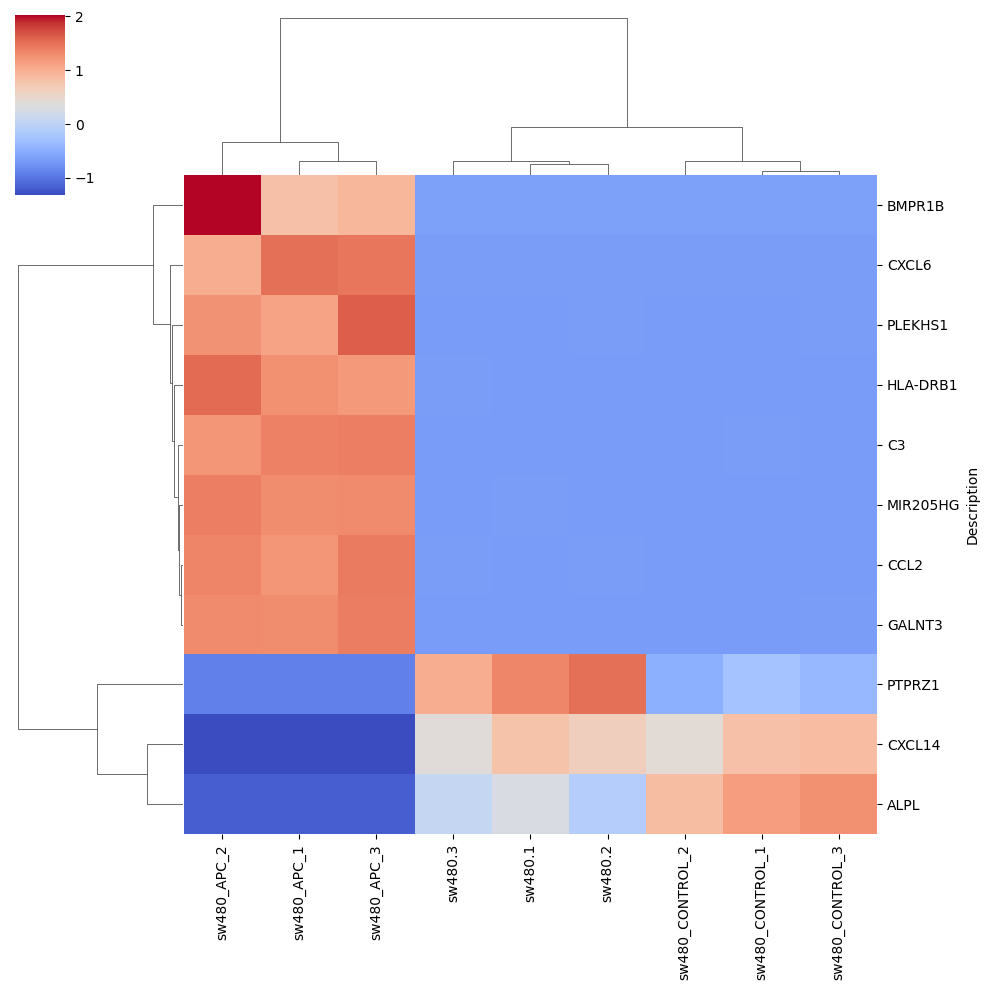

In [47]:
heatmap_genes = TPM_data.T[smallset].T

heatmap_genes = heatmap_genes.loc[~(heatmap_genes==0).all(axis=1)]

import seaborn as sns
sns.clustermap(heatmap_genes, z_score= 0, metric= "euclidean", cmap = "coolwarm")
plt.show()

## Checking for internal consistency

Our smallset should resemble the larger set; a straightforward way to check this is to repeat GSEA on the new set. Examining the top terms we find a reasonable match- but of course this should be guided by your interest in the biology.

In [48]:
enr = gp.enrichr(gene_list=smallset, # or "./tests/data/gene_list.txt",
                 gene_sets=['MSigDB_Hallmark_2020','KEGG_2021_Human'],
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

In [49]:
enr.results.sort_values(by=['Adjusted P-value'])
enr.results[enr.results["Adjusted P-value"]<0.05]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,2/200,0.005157,0.027504,0,0,22.212121,117.000045,CXCL6;CCL2
1,MSigDB_Hallmark_2020,Interferon Gamma Response,2/200,0.005157,0.027504,0,0,22.212121,117.000045,CCL2;HLA-DRB1
2,MSigDB_Hallmark_2020,Inflammatory Response,2/200,0.005157,0.027504,0,0,22.212121,117.000045,CXCL6;CCL2
16,KEGG_2021_Human,Cytokine-cytokine receptor interaction,4/295,0.000014,0.000356,0,0,38.680412,432.021505,CXCL6;CCL2;BMPR1B;CXCL14
17,KEGG_2021_Human,Rheumatoid arthritis,3/93,0.000016,0.000356,0,0,82.912500,917.527195,CXCL6;CCL2;HLA-DRB1
18,KEGG_2021_Human,Viral protein interaction with cytokine and cy...,3/100,0.000019,0.000356,0,0,76.902062,834.256871,CXCL6;CCL2;CXCL14
19,KEGG_2021_Human,Chemokine signaling pathway,3/192,0.000136,0.001867,0,0,39.285714,349.817130,CXCL6;CCL2;CXCL14
20,KEGG_2021_Human,Pertussis,2/76,0.000767,0.007212,0,0,59.804805,429.015805,C3;CXCL6
21,KEGG_2021_Human,Leishmaniasis,2/77,0.000787,0.007212,0,0,59.004444,421.739196,C3;HLA-DRB1
22,KEGG_2021_Human,IL-17 signaling pathway,2/94,0.001169,0.008210,0,0,48.060386,324.471367,CXCL6;CCL2


## Exploring the literature for connectivity

Here we explore different databases of gene interactions to assist developing a network model. APC need to be added to our list of genes of interest as changes in expression should be expected to flow from APC mutation.

### HuRI

HuRI (http://www.interactome-atlas.org/search) is a powerful resource summarising both the literature and a high-throughput interaction screen. We can use this to propose connectivity. To explore this we enter our gene names into the search bar, and it links genes taht are either connected in the experiment, or through the teams review of the literature. Our list however includes several genes not found in its database

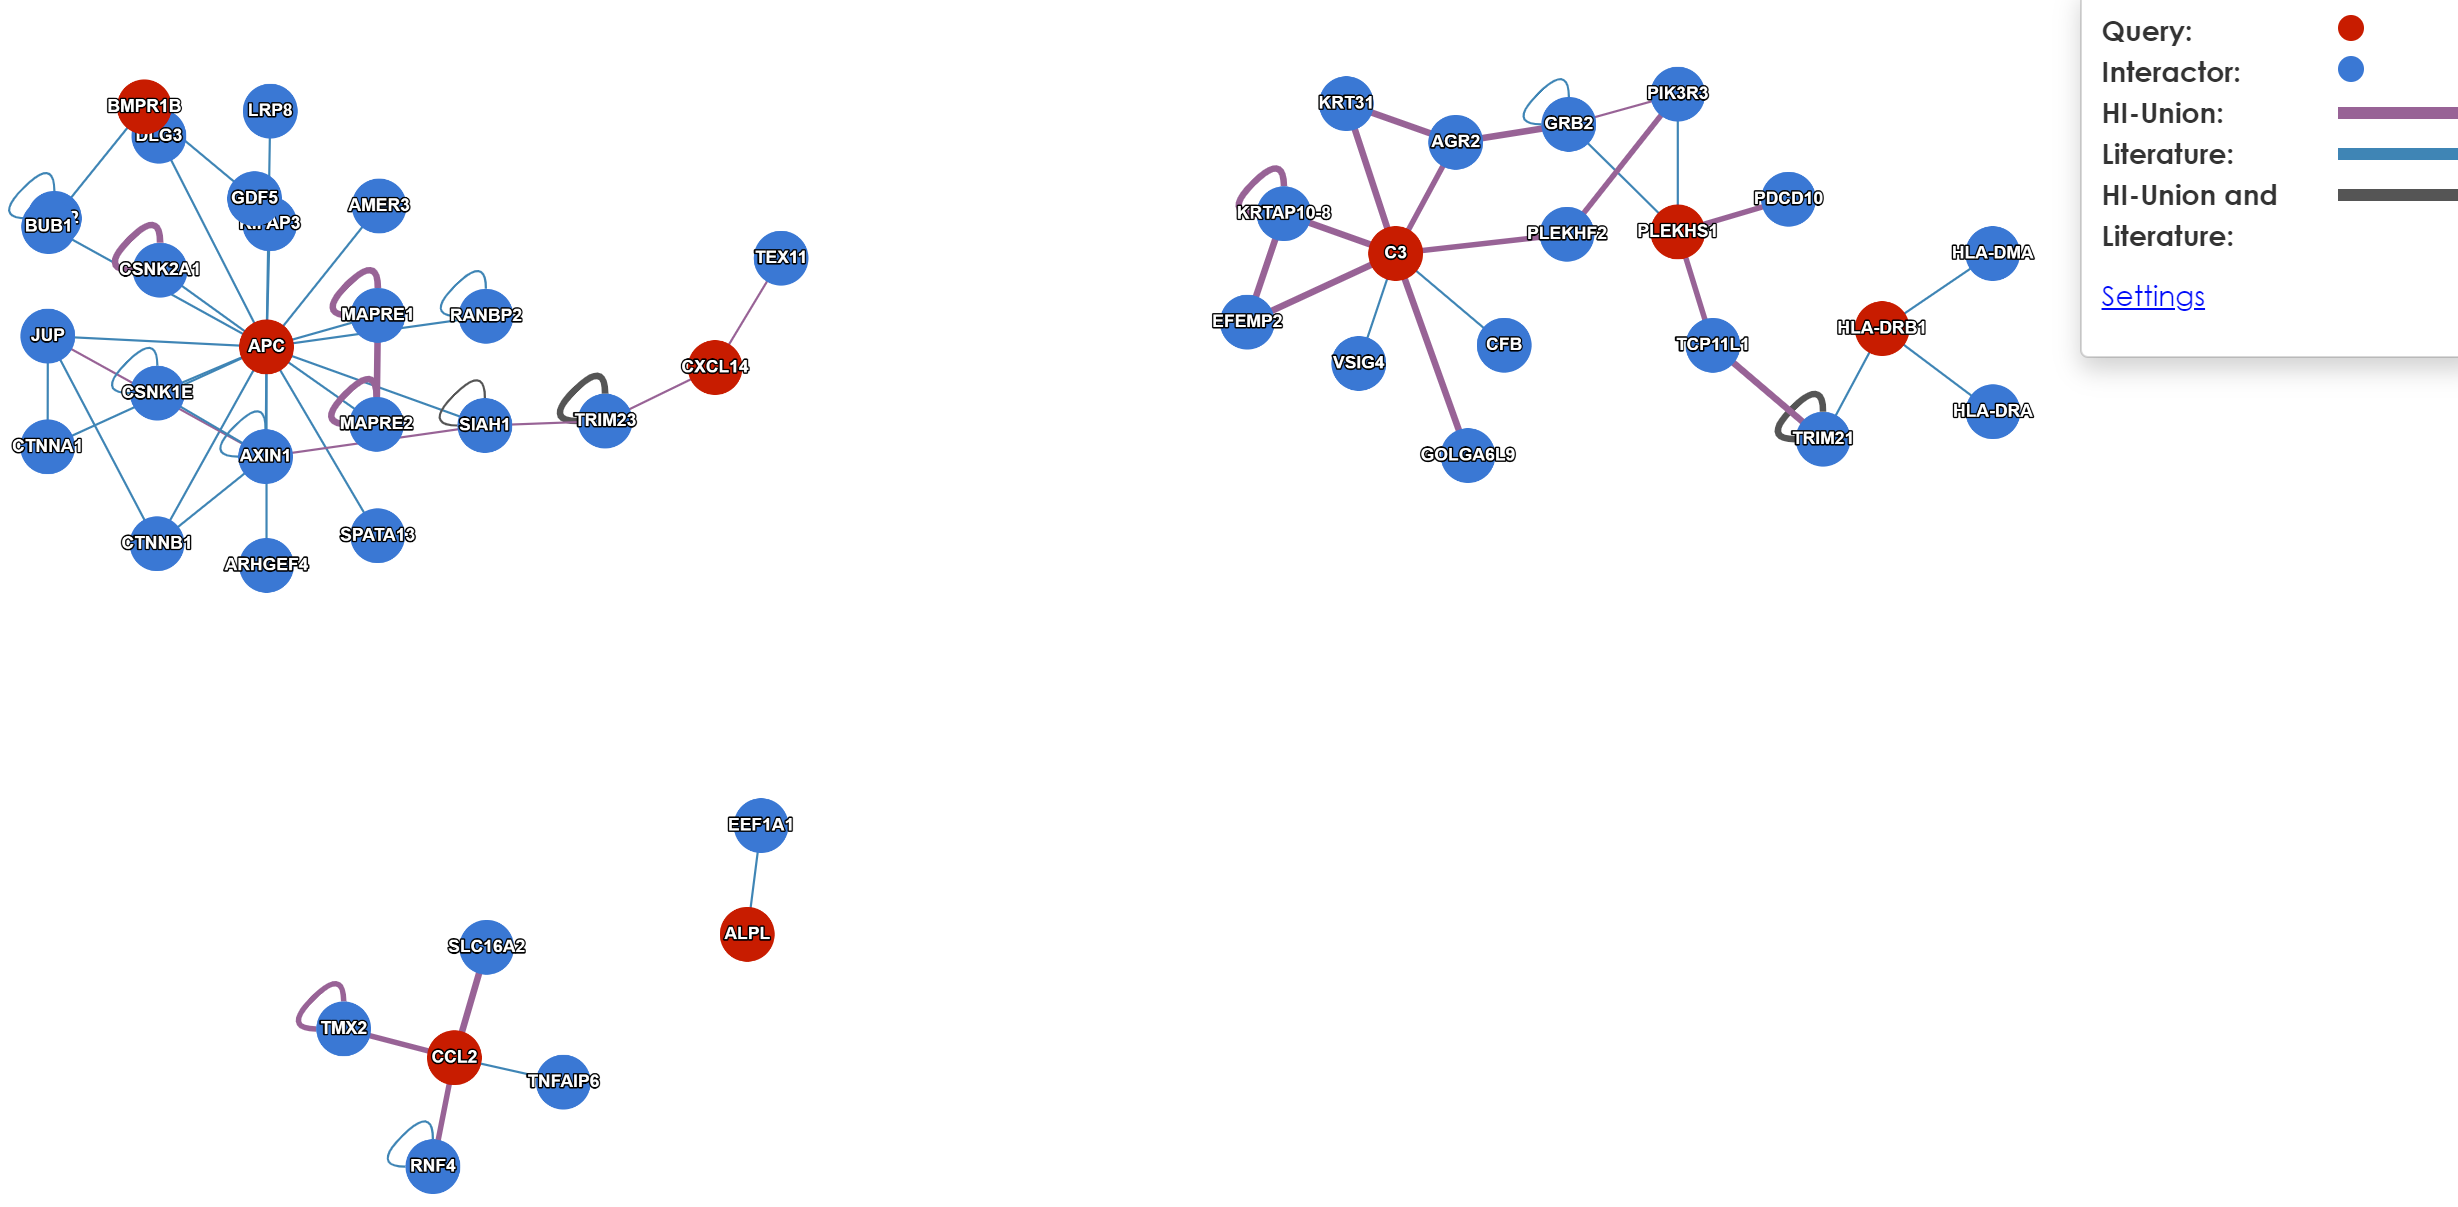

Examination of the networks reveal that those genes found are not directly connected by the HuRI experiment, and can only be linked indirectly through the literature. Moreover, APC has limited connectivity to the selected genes, limiting its usefulness

How plausible are the new interaction partners? A simple way to address that is to reexamine the original list and ask which of these new genes are members

In [50]:
## Read in the list of genes from huri
huri = pd.read_csv("HuRI_download_interactors_feb_08_2024_18_19_44.csv", usecols=range(5))

hurigenes = list(huri["Gene Name"])

print(len(hurigenes))

## Look at the overlap with our gene list
print(set(APCrest_genes) & set(hurigenes))

56
{'BMP2', 'CXCL14', 'CCL2', 'HLA-DRB1', 'HLA-DRA', 'ALPL', 'PLEKHS1', 'BMPR1B', 'C3'}


Of 56, only only 9 are found in both lists. For this task, HuRI is not sufficient on its own, but for other gene lists it may be better.

### GeneMania

Whilst the microRNA MIR205G is unrecognised, all other genes are found and co-expression and co-localisation generate a network of genes. Different plots show the complexity of the network, but gene interactions, taken from Lin et al 2010 (https://pubmed.ncbi.nlm.nih.gov/20508145/) offer a useful starting place, connecting most genes in the set to APC. We can run this through the genemania website https://genemania.org/, or through a plugin installed in cytoscape. The interface is similar to HuRi.

#### All

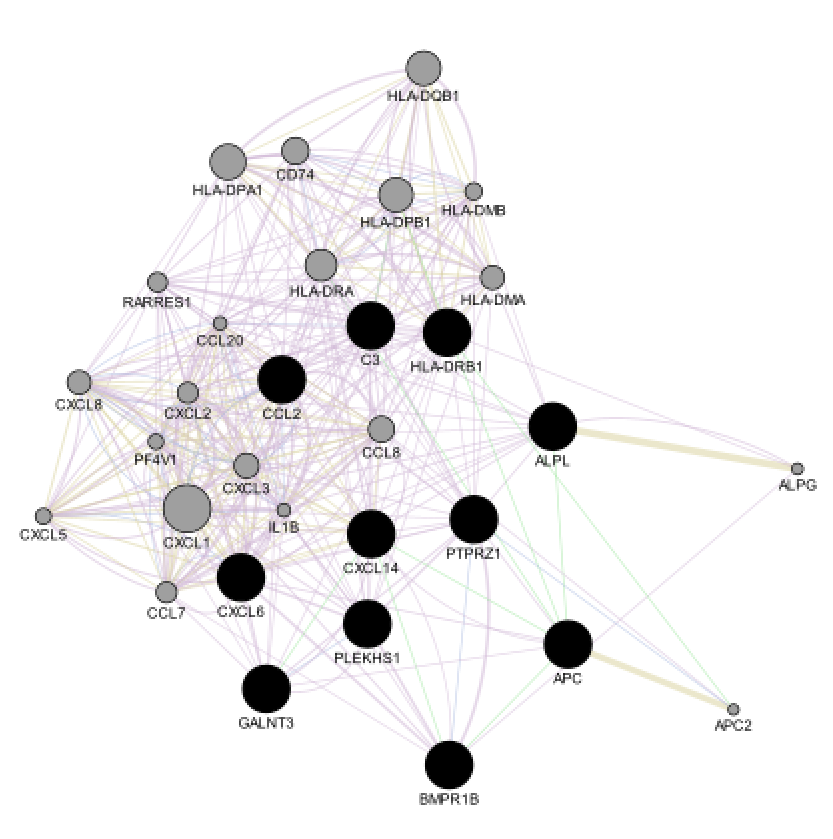

#### Co-localisation (blue) and gene interactions (green)

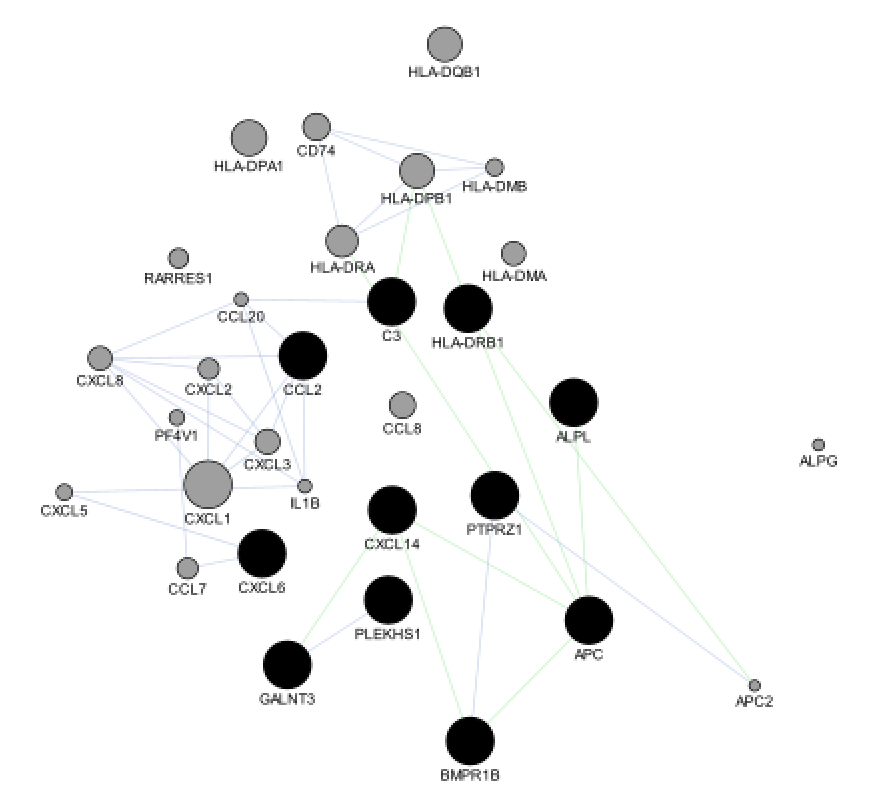

#### Co-expression alone

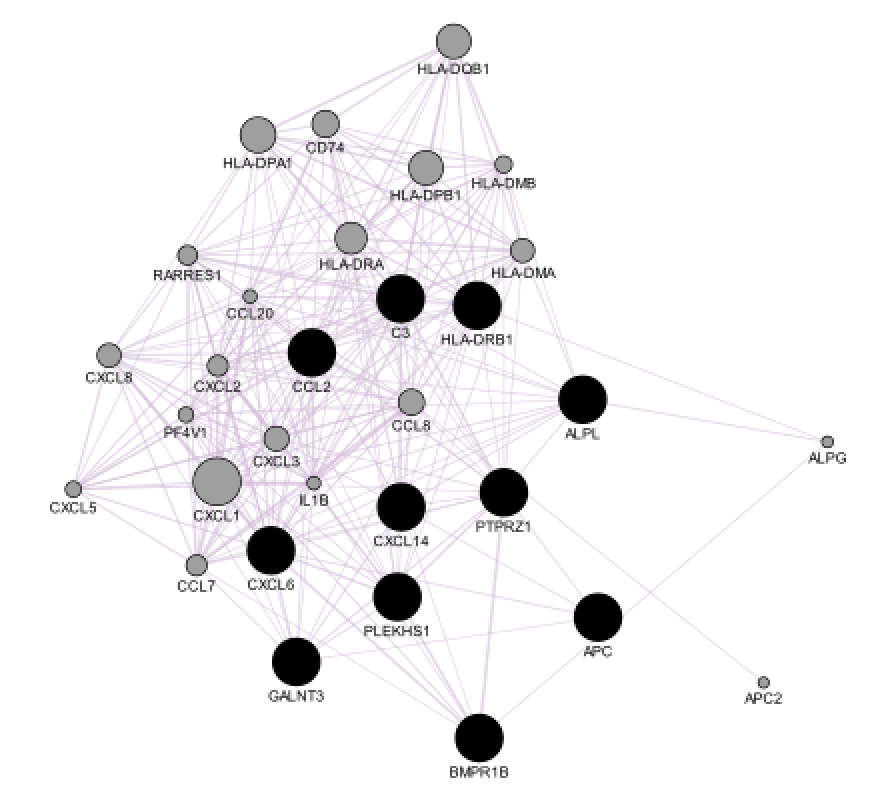

In [51]:
genemaniaTXT = """ALPG
ALPL
BMPR1B
C3
CCL2
CCL20
CCL7
CCL8
CD74
CXCL1
CXCL14
CXCL2
CXCL3
CXCL5
CXCL6
CXCL8
GALNT3
HLA-DMA
HLA-DMB
HLA-DPA1
HLA-DPB1
HLA-DQB1
HLA-DRA
HLA-DRB1
IL1B
LTF
PF4V1
PLEKHS1
PTPRZ1
RARRES1"""

genemania = set(genemaniaTXT.split("\n")) - set(smallset)
print(list( genemania & set(APCrest_genes)))

['CXCL2', 'HLA-DQB1', 'IL1B', 'CXCL5', 'CCL20', 'CXCL3', 'HLA-DRA', 'HLA-DPB1', 'CD74', 'CXCL1']


Where do the links come from? 

A genome-wide map of human genetic interactions inferred from radiation hybrid genotypes.. Lin, et al. (2010.0). Genome Res.

High throughput screen- not direct evidence so need to find protein protein interactions.

## Omnipath to find edges between genes  

Can be done with literature review but here we're emphasising programatic analysis.

Does APC connect directly to these genes? No

https://omnipathdb.org/interactions/?genesymbols=1&partners=APC

```
source	target	source_genesymbol	target_genesymbol	is_directed	is_stimulation	is_inhibition	consensus_direction	consensus_stimulation	consensus_inhibition
P04637	P25054	TP53	APC	1	1	1	1	0	1
P67775	P25054	PPP2CA	APC	1	0	1	1	0	1
P49841	P25054	GSK3B	APC	1	1	0	1	1	0
P25054	P06746	APC	POLB	1	0	1	1	0	1
P25054	P39748	APC	FEN1	1	0	1	1	0	1
P25054	P35222	APC	CTNNB1	1	1	1	1	0	1
COMPLEX:P20248_P24941	P25054	CCNA2_CDK2	APC	1	0	1	1	0	1
COMPLEX:P67870_P68400	P25054	CSNK2A1_CSNK2B	APC	1	1	0	1	1	0
O15169	P25054	AXIN1	APC	1	1	0	1	1	0
Q9Y2T1	P25054	AXIN2	APC	1	1	0	1	1	0
O14640	P25054	DVL1	APC	1	0	1	1	0	1
Q05901	P25054	CHRNB3	APC	1	1	0	1	1	0
P17612	P25054	PRKACA	APC	1	0	1	1	0	1
P49674	P25054	CSNK1E	APC	1	1	0	1	1	0
P04264	P25054	KRT1	APC	1	1	0	1	1	0
Q5JTC6	P25054	AMER1	APC	1	1	0	1	1	0
O60729	P25054	CDC14B	APC	1	1	0	1	1	0
P25054	Q9UNN8	APC	PROCR	1	0	0	0	0	0
P48729	P25054	CSNK1A1	APC	1	1	0	1	1	0
P24941	P25054	CDK2	APC	1	0	0	0	0	0
P48730	P25054	CSNK1D	APC	1	1	0	1	1	0
Q9HCP0	P25054	CSNK1G1	APC	1	0	0	0	0	0
Q8N752	P25054	CSNK1A1L	APC	1	0	0	0	0	0
P78368	P25054	CSNK1G2	APC	1	0	0	0	0	0
Q9Y6M4	P25054	CSNK1G3	APC	1	0	0	0	0	0
P05771	P25054	PRKCB	APC	1	0	0	0	0	0
Q13976	P25054	PRKG1	APC	1	0	0	0	0	0
```

## Omnipath to find paths between genes

Use R to find paths between pairs of genes. To perform this, we use R and the omnipathR library,which need to be installed through the notebook itself. Below is a summary of some results, but for this project we encourage you to return to the notebook to experiment once you have finished the main tutorial.

Using Signor, Phosphosite, and signalink3 we find only one path. To achieve this we first import the interactions from omnipath, initially selecting a subset of resources and turning them into an igraph object.
```
interactions <- import_omnipath_interactions(
    resources = c('SignaLink3', 'PhosphoSite', 'SIGNOR', 'ACSN')
)
OPI_g = interaction_graph(interactions = interactions)
print_path_es(shortest_paths(OPI_g,from = 'APC',to = 'BMPR1B',output = 'epath')$epath[[1]],OPI_g)
           source interaction          target n_resources
1    APC (P25054)  ==(+/-)==> CTNNB1 (P35222)          12
2 CTNNB1 (P35222)  ==( + )==>  SMAD7 (O15105)           4
3  SMAD7 (O15105)  ==( + )==> BMPR1B (O00238)           2
```
We can infer that 1 must be negative for loss of APC to cause a rise in BMPR1B

Use get_interaction_resources() to explore alternative resources

If we look at everything (don't include a resource link in import_omnipath) we can find more, but the quality drops
```
> print_path_es(shortest_paths(OPI_g,from = 'APC',to = 'C3',output = 'epath')$epath[[1]],OPI_g)
           source interaction          target n_resources
1    APC (P25054)  ==(+/-)==> CTNNB1 (P35222)          12
2 CTNNB1 (P35222)  ==(+/-)==> CREBBP (Q92793)           6
3 CREBBP (Q92793)  ==( + )==>    JUN (P05412)           6
4    JUN (P05412)  ==( + )==>   SPI1 (P17947)           3
5   SPI1 (P17947)  ==( ? )==>   CTSG (P08311)           1
6   CTSG (P08311)  ==( + )==>     C3 (P01024)           4
```
we can infer that 5 or 2 must be either both positive or negative so that loss of APC causes a rise in C3 (if 1 is negative because of the links to BMPR1B)
```
> print_path_es(shortest_paths(OPI_g,from = 'APC',to = 'PTPRZ1',output = 'epath')$epath[[1]],OPI_g)
           source interaction          target n_resources
1    APC (P25054)  ==(+/-)==> CTNNB1 (P35222)          12
2 CTNNB1 (P35222)  ==(+/-)==> CREBBP (Q92793)           6
3 CREBBP (Q92793)  ==( + )==>  CREB1 (P16220)          11
4  CREB1 (P16220)  ==( + )==>   GDNF (P39905)           3
5   GDNF (P39905)  ==( + )==>  NCAM1 (P13591)           2
6  NCAM1 (P13591)  ==( ? )==> PTPRZ1 (P23471)           2
```
Similarly we can infer that 2 and 6 must be differently signed for loss of APC to lead to a loss of PTPRZ1 (if 1 is negative because of the links to BMPR1B).

We can continue to explore this set and our expanded target set from genemania, but for now we progress with these three links to using cell designer.

### Making a first map in cell designer

We will make a first map of gene interactions based on our findings in the tool cell designer. We will build it as a activity flow diagram. Other mapping types are possible (from https://pubmed.ncbi.nlm.nih.gov/32403123/)

>The Systems Biology Graphical Notation (SBGN) scheme uses three different languages for network representation (Le Novère, 2015). First, the activity flow (AF) diagram that is an interaction network, which includes influence direction and mode of regulation, such as activation and inhibition. Second, the entity-relationship (ER) representation that includes mechanistic details, the direction of influences but no sequential information and third, the process description diagram (PD) which is the most detailed of all, including details of the direction of influences, mechanism of action and the order of events. The SBGN-PD notation scheme is based on ideas first introduced to the field by Hiroaki Kitano and co-workers (2003).

#### Why build in CellDesigner and not immediately in BMA? 

This could be faster to build directly in your preferred modelling platform. However, there is a value in developing a map first and a model later. Firstly, celldesigner is built for mapping, and has several tools that assist gene annotation. This can be useful for storing information about where the gene interactions come from, and assist future modellers in the field. 

Secondly, it can be argued that the separation of mapping (based on the literature) and modelling (based on the analysis of model dynamics) can be insightful in itself. Maps can be built from a wide range of sources, not all of them important in all scenarios. By separating the dynamics from the literature analysis, it makes it more explicit if the functional connectivity is not consistent with the literature, and why you've gone against it. This again helps users of the model downstream, but it also assists you identify novel predictions from your model.

We include it in this tutorial to illustrate how it can be used, but the choice is up to you in your own projects.

#### Getting building

All the elements you need to add are in the top row. We're using the most simple set here to make a quick model.

Add genes in the user interface with the generic protein icon (click, drop and rename). To represent gene activations, simply link them with the state transition arrows. Where there is an inhibition, you need to add in an inactive form of the gene. This should be connected to the active form with a state transition arrow. You can then add an inhibition from the source gene to the state transition arrow.

We have simplified the map by reducing the number of intermediary connections connecting APC to its downstream elements. Note that these may become more important later on in modelling, but for simplicity we're omitting them. This model is available to you in the map folder.

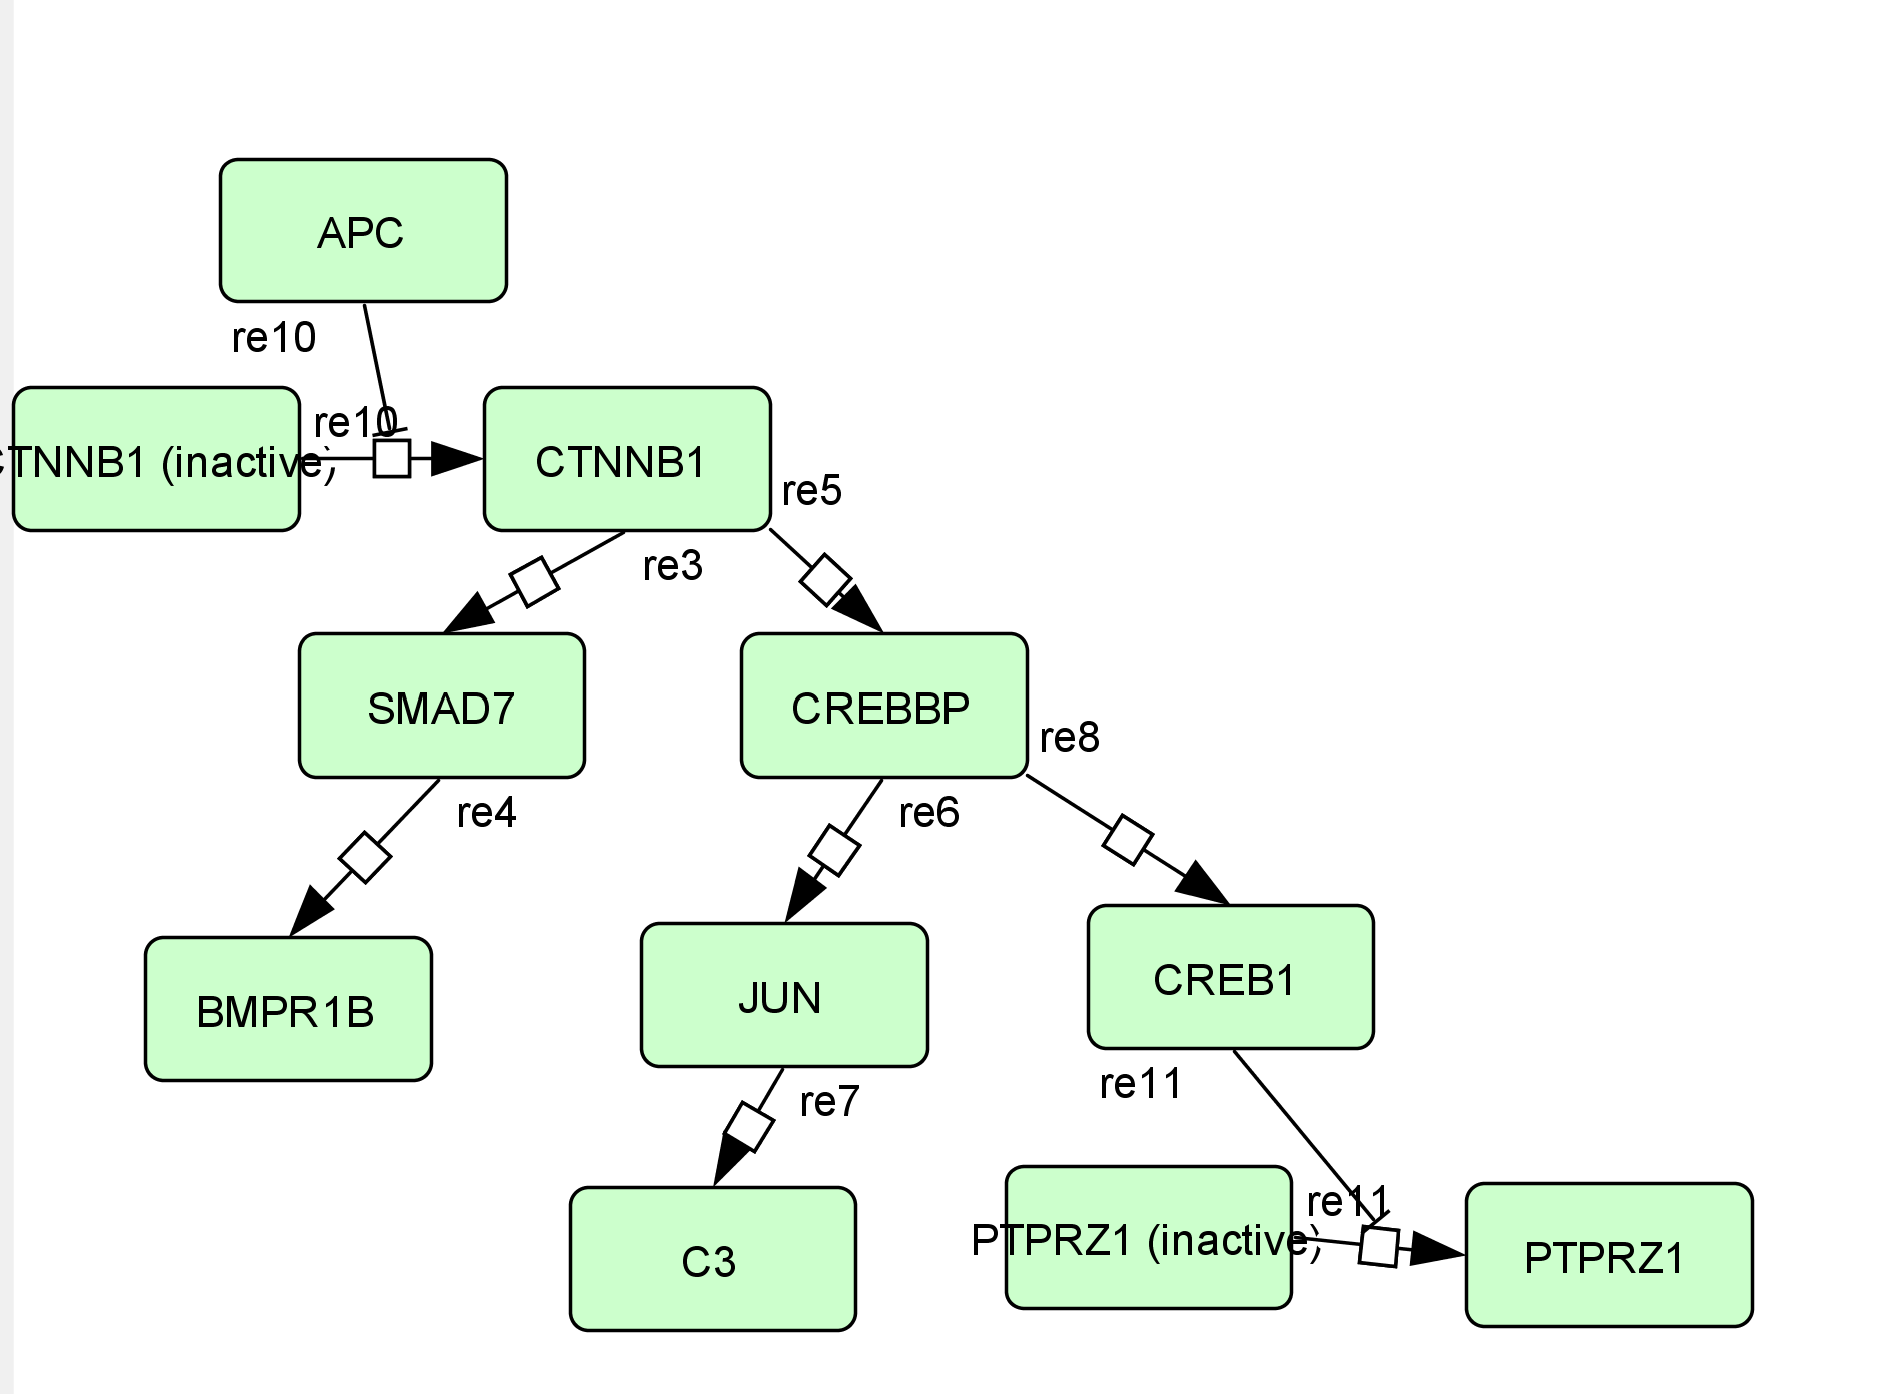

### CaSQ

CaSQ is a tool for the conversion of maps into models, following a formal analysis of the map which ensures that selected target functions are consistent with what is seen. This will be convered in more depth later on in the course, but for now we will use this to create a BMA model from our map. 

If it is not available on our system, we can install with pip first. We then take our saved map from CellDesigner (APC.map) and convert it into a BMA json format using the defaults, leading to a Boolean network model. Open a terminal (the command line interface), first install casq (the pip command), then run casq on your saved model. Our conversion is stored in the map folder for comparison.

>pip install casq
>
>casq APC.xml APC.json -b


### BMA

At this stage you now have a model you can analyse, and check to see if it works as expected! BMA is a modelling tool that allows you to perform different analyses of model behaviour. 

First we need to import our model from disk. Click the arrow next to the model name on the left hand side of the screen, and click the import button (3rd from left) to select the model from the disk. Make sure to load the json as other formats are not recognised.

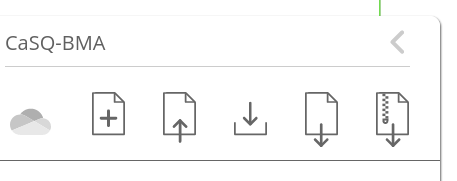

Loaded into the browser gives us this model, that reflects our original map. we next need to check the model dynamics match the expected gene expression patterns from differential expression.

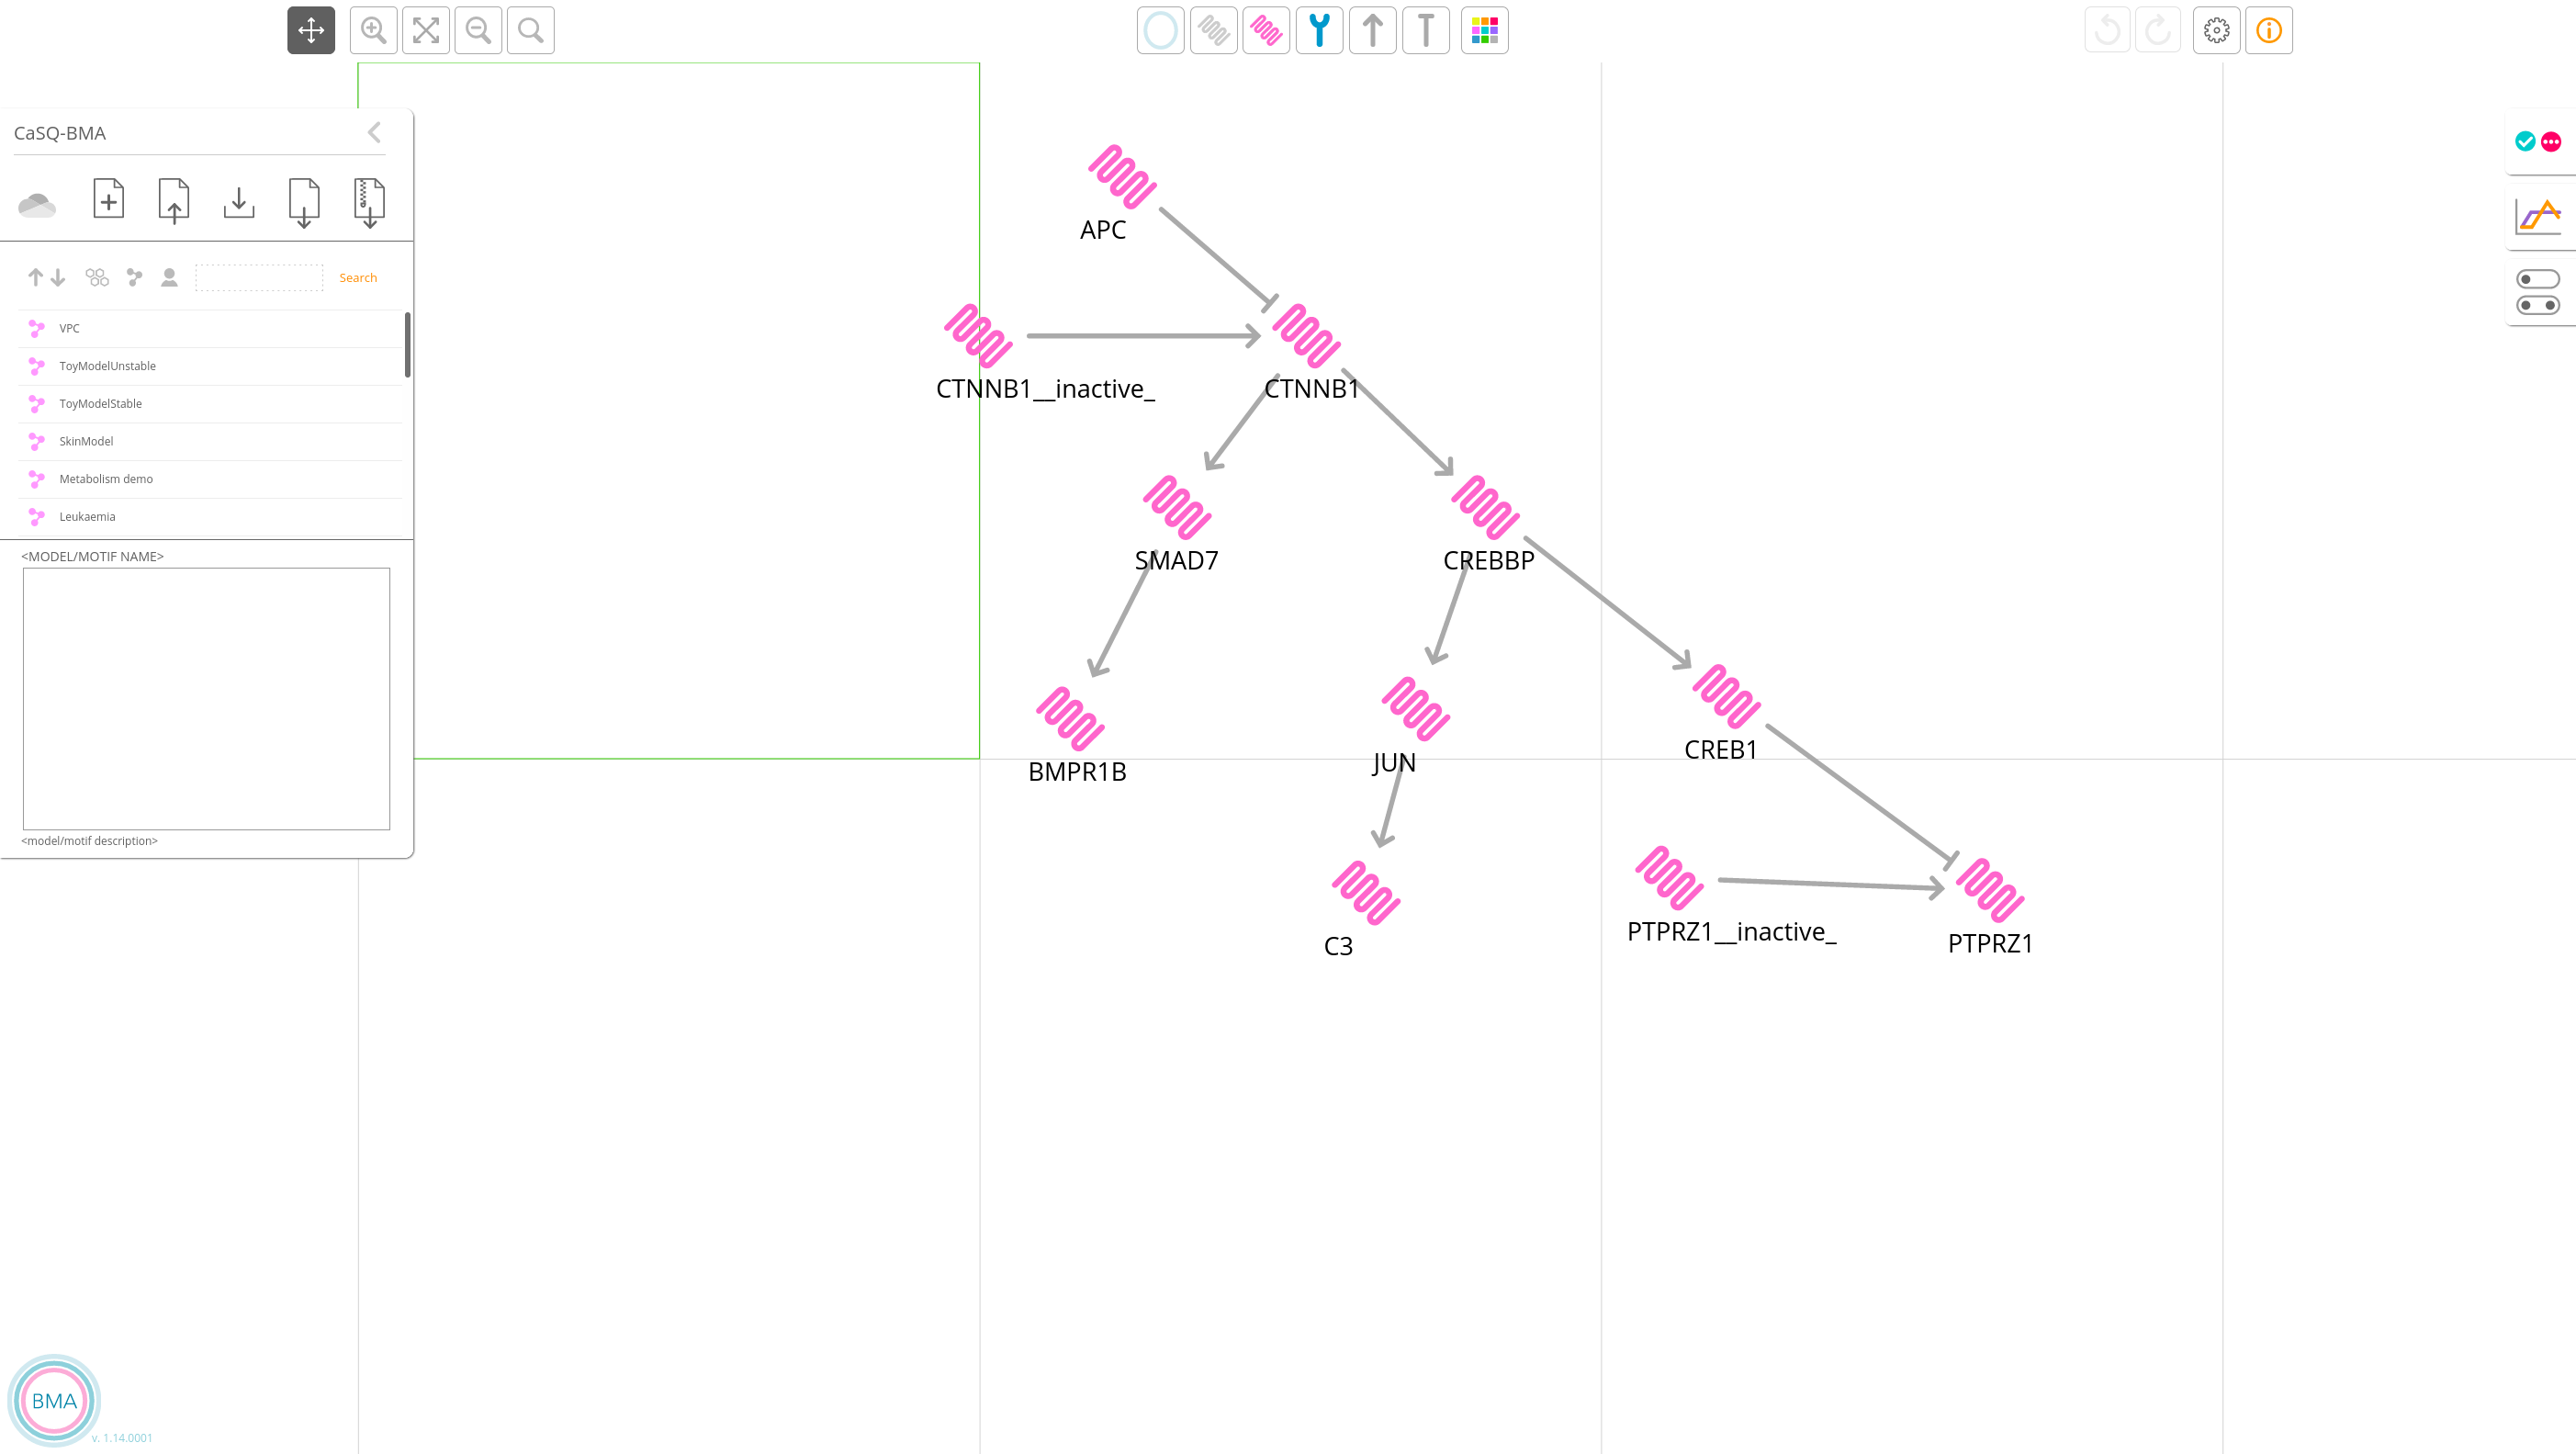

We are going to use `stability testing` to verify our model in the presence and absence of APC mutation. This tests whether the model represents homeostasis accurately, and reports the homoestatic state. Click this button on the right to run the analysis.

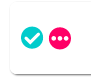

An initial analysis of the CaSQ output shows us the gene expression when APC is active (the value is one). Once the model is proven stable (i.e. at homeostasis), we can check the state of BMPR1B, C3, and PTPRZ1 by checking the value next to each gene. This shows us that BMPR1B and C3 are off, and PTPRZ1 is active

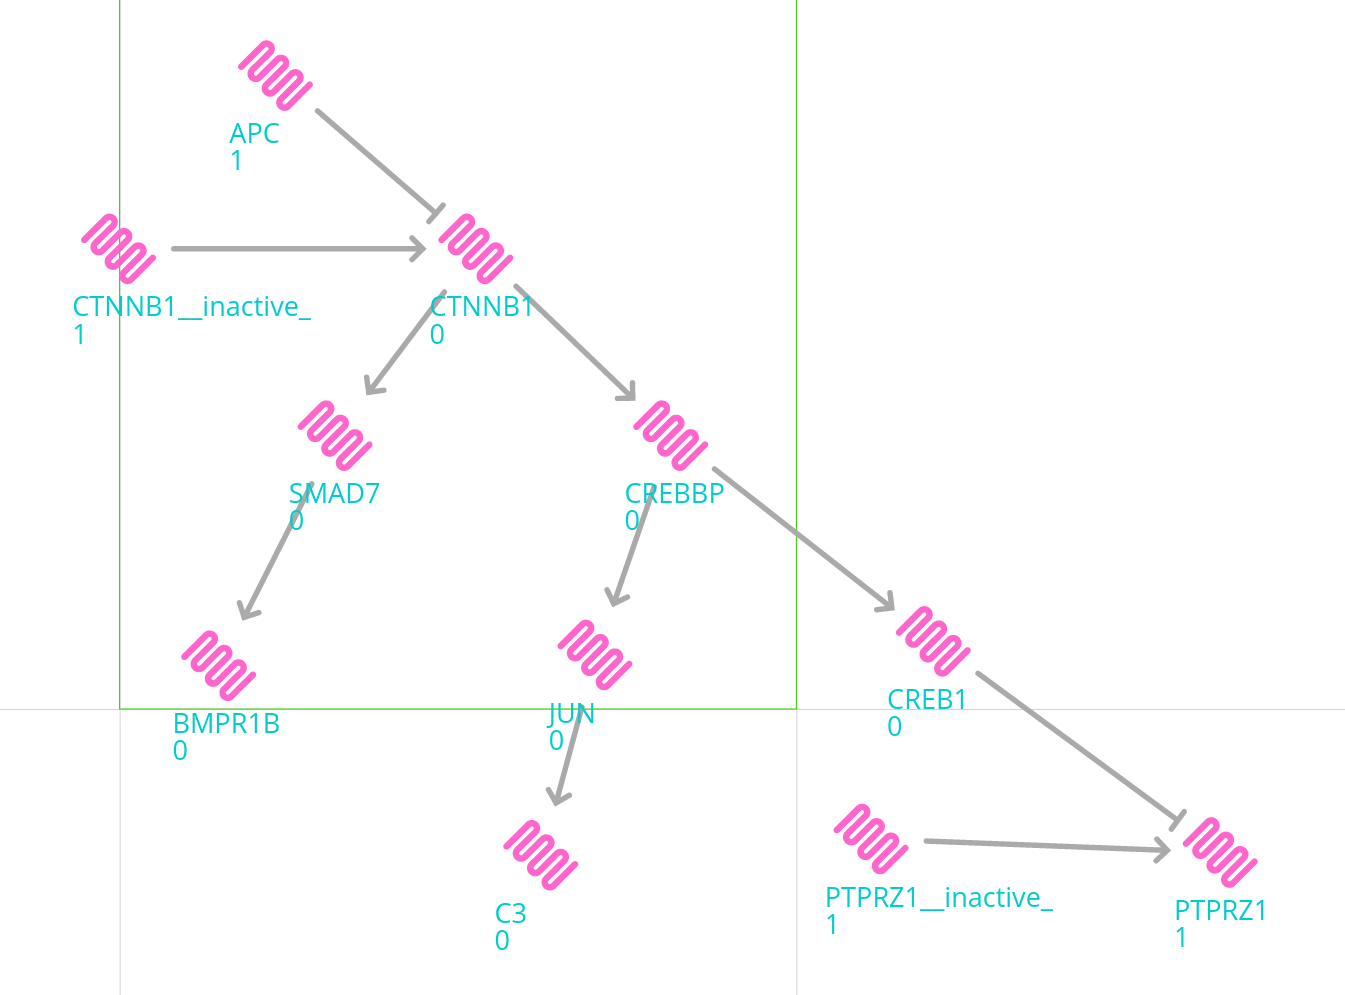

We can then mutate (turn off APC) and retest. To deactivate APC, right click the gene and select edit. In the dialogue box, replace the default function (1) with zero to simulate the mutation.

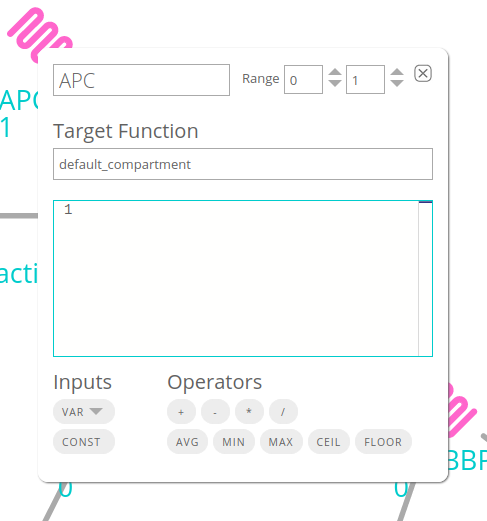

Then repeat the stability analysis, revealing the change in downstream gene activity. This shows our initial model works as expected, reproducing gene activity measured by expression!

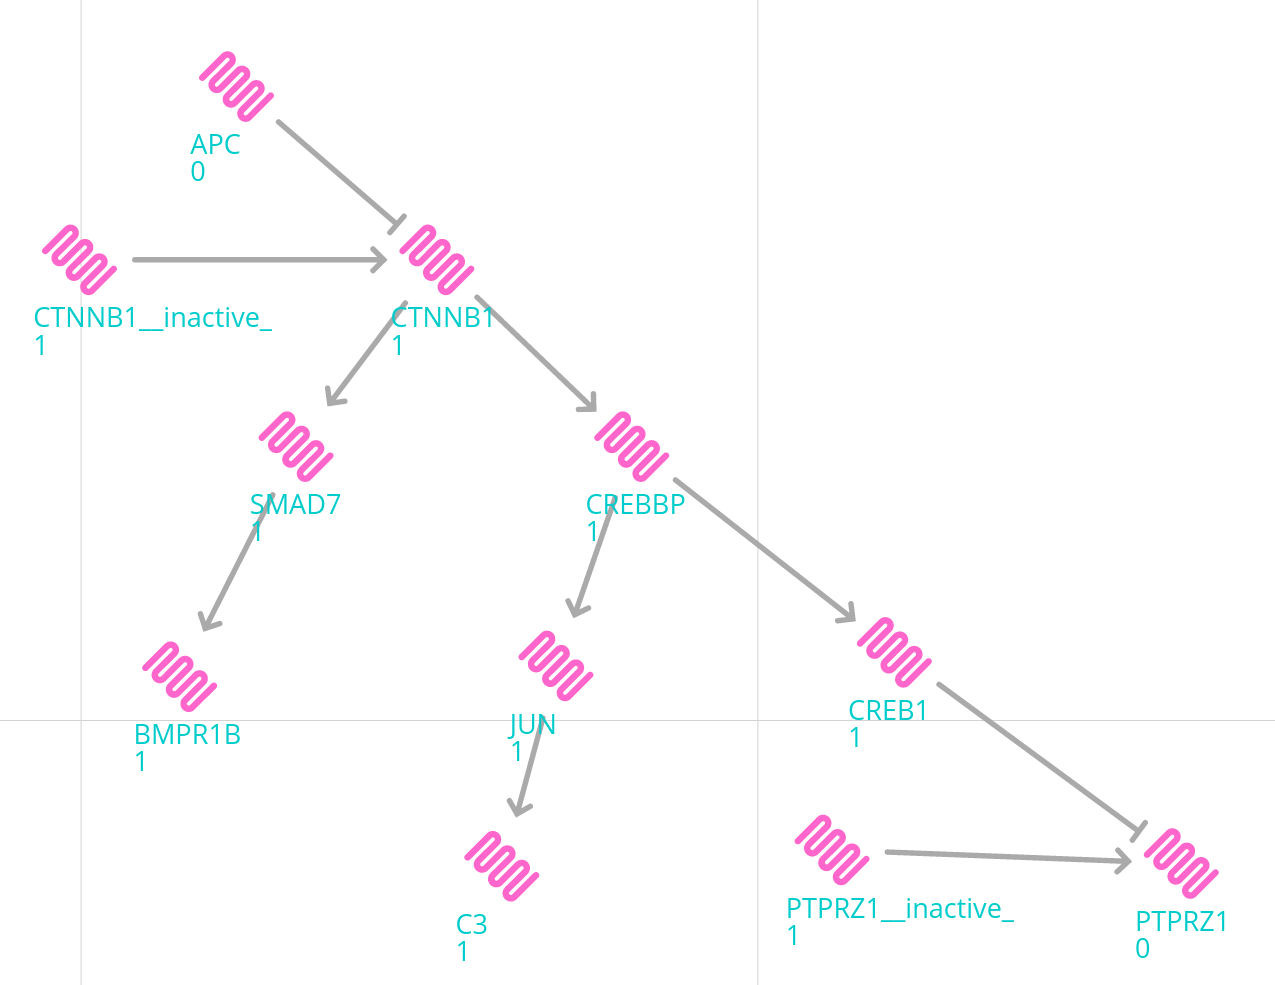

## Continuing the practical

This is only intended as a quick introduction, and there are many more steps that could be taken to build out the network.If you reach this before the end of the session, we recommend you revisit earlier steps to extend the model. This could include 
* adding extra downstream genes
* considering pathway cross talk by searching for paths between intermediary genes
* suggesting ways to connect other genes of interest (either from DeSEQ or genes of known biological importance)